In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
train_df = pd.read_csv("C:/Users/USER/Desktop/pyp2/train.csv").sample(frac=0.1, random_state=42)
questions_df = pd.read_csv("C:/Users/USER/Desktop/pyp2/questions.csv")
lectures_df = pd.read_csv("C:/Users/USER/Desktop/pyp2/lectures.csv")

# Предварительная обработка данных
def preprocess_data(train, questions, lectures):
    """
    Функция для предварительной обработки данных.
    
    Параметры:
    train (DataFrame): Данные о прохождении тестов студентами.
    questions (DataFrame): Данные о вопросах.
    lectures (DataFrame): Данные о лекциях.
    
    Возвращает:
    DataFrame: Обработанные данные, объединенные с информацией о вопросах и лекциях.
    """
    # Обработка пропусков в данных train_df
    train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].fillna(train['prior_question_elapsed_time'].mean())
    train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(False).infer_objects(copy=False)
    
    # Объединение train и questions по content_id для получения информации о вопросах
    train = pd.merge(train, questions, how="left", left_on="content_id", right_on="question_id")
    
    # Объединение train и lectures по content_id для получения информации о лекциях
    train = pd.merge(train, lectures, how="left", left_on="content_id", right_on="lecture_id")
    
    # Заполнение пропусков в столбце 'part' после объединения
    train['part'] = train['part_x'].fillna(train['part_y'])
    
    # Удаление лишних столбцов после объединения
    train.drop(columns=['part_x', 'part_y', 'question_id', 'lecture_id'], inplace=True)
    
    return train

train_df = preprocess_data(train_df, questions_df, lectures_df)

# Анализ признаков
def analyze_features(data):
    """
    Функция для анализа различных признаков, влияющих на успеваемость студентов.
    
    Параметры:
    data (DataFrame): Обработанные данные.
    """
    # Проверка наличия столбца 'part'
    if 'part' not in data.columns:
        print("Столбец 'part' отсутствует в данных. Пропускаем анализ по темам.")
        return
    
    # Распределение времени на вопросы
    plt.figure(figsize=(10, 6))
    plt.hist(data['prior_question_elapsed_time'], bins=30, alpha=0.7)
    plt.title("Распределение времени на предыдущий вопрос")
    plt.xlabel("Время (мс)")
    plt.ylabel("Частота")
    plt.show()
    
    # Влияние объяснений на правильные ответы
    # Группировка по признаку наличия объяснения и расчет среднего значения правильных ответов
    explanation_influence = data.groupby('prior_question_had_explanation')['answered_correctly'].mean()
    explanation_influence.plot(kind='bar', figsize=(8, 5))
    plt.title("Влияние объяснений на правильные ответы")
    plt.xlabel("Был ли показан объясняющий материал")
    plt.ylabel("Средний процент правильных ответов")
    plt.show()
    
    # Успеваемость по темам (part)
    # Группировка по темам и расчет среднего процента правильных ответов
    part_analysis = data.groupby('part')['answered_correctly'].mean()
    part_analysis.plot(kind='bar', figsize=(12, 6))
    plt.title("Успеваемость студентов по темам")
    plt.xlabel("Тема")
    plt.ylabel("Процент правильных ответов")
    plt.show()
    
    # Анализ влияния тегов
    # Заполнение пропусков в тегах и выборка 10 самых популярных тегов
    data['tags'] = data['tags'].fillna("unknown")
    top_tags = data['tags'].value_counts().index[:10]
    tag_data = data[data['tags'].isin(top_tags)]
    tag_analysis = tag_data.groupby('tags')['answered_correctly'].mean()
    tag_analysis.plot(kind='bar', figsize=(12, 6))
    plt.title("Успеваемость студентов по популярным тегам")
    plt.xlabel("Тег")
    plt.ylabel("Процент правильных ответов")
    plt.xticks(rotation=45)
    plt.show()

analyze_features(train_df)

# Функция для анализа временных признаков
def time_based_analysis(data):
    """
    Анализ временных признаков, влияющих на правильность ответов.
    
    Параметры:
    data (DataFrame): Обработанные данные.
    """
    # Разбиение времени на интервалы и группировка по ним для анализа правильности ответов
    data['response_time_bins'] = pd.qcut(data['prior_question_elapsed_time'], q=10)
    response_time_analysis = data.groupby('response_time_bins', observed=False)['answered_correctly'].mean()
    
    response_time_analysis.plot(kind="bar", figsize=(12, 6))
    plt.title("Зависимость правильных ответов от времени на вопрос")
    plt.xlabel("Время на предыдущий вопрос (интервалы)")
    plt.ylabel("Процент правильных ответов")
    plt.show()

time_based_analysis(train_df)

# Функция для анализа лекций
def lecture_analysis(data):
    """
    Анализ влияния различных типов лекций на успешность студентов.
    
    Параметры:
    data (DataFrame): Обработанные данные.
    """
    # Группировка данных по типам лекций и расчет среднего процента правильных ответов
    lecture_influence = data[data['content_type_id'] == 1].groupby('type_of')['answered_correctly'].mean()
    
    if not lecture_influence.empty:
        lecture_influence.plot(kind="bar", figsize=(10, 5))
        plt.title("Влияние различных типов лекций на успеваемость")
        plt.xlabel("Тип лекции")
        plt.ylabel("Процент правильных ответов")
        plt.show()

lecture_analysis(train_df)

# Финальная обработка и вывод общей информации
def final_analysis(data):
    """
    Функция для выполнения финального анализа и создания отчета.
    
    Параметры:
    data (DataFrame): Обработанные данные.
    """
    # Общее количество студентов
    unique_users = data['user_id'].nunique()
    print(f"Общее количество студентов: {unique_users}")
    
    # Средний процент правильных ответов
    avg_correct = data['answered_correctly'].mean()
    print(f"Средний процент правильных ответов: {avg_correct:.2%}")
    
    # Статистика по темам
    if 'part' in data.columns:
        topic_stats = data.groupby('part')['answered_correctly'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
        print("Статистика по темам:")
        print(topic_stats)

final_analysis(train_df)


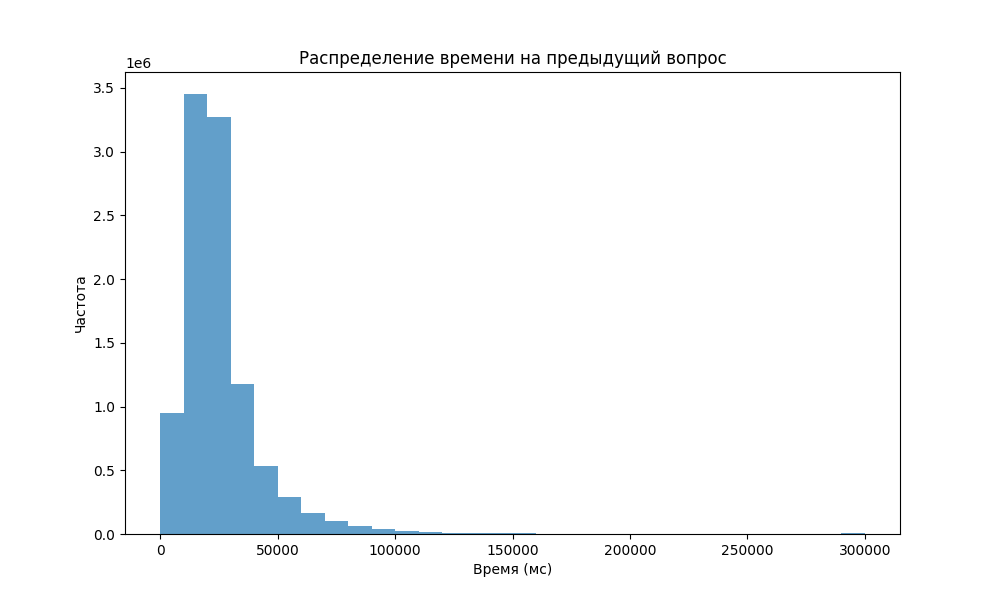 
### Распределение времени на предыдущий вопрос

График ниже представляет распределение времени, которое студенты тратили на предыдущий вопрос. 

**Наблюдения:**
- Большинство студентов тратили менее 50 000 мс (50 секунд) на предыдущий вопрос.
- Распределение имеет ярко выраженный правый хвост, что говорит о наличии значительного числа студентов, которые тратили гораздо больше времени, что является выбросом.
- Основная масса времени сосредоточена в диапазоне от 0 до 50 000 мс, а затем частота резко снижается.
  
**Интерпретация:**
- Большая концентрация времени около начала распределения может указывать на то, что большинство вопросов были относительно простыми для студентов.
- Однако наличие большого количества выбросов (времени более 100 000 мс) может свидетельствовать о сложных вопросах или отвлечениях во время выполнения заданий.

**Рекомендации:**
- Возможно, стоит отдельно анализировать студентов, которые затратили время значительно больше среднего, чтобы понять причины (например, сложность вопроса или потеря внимания).
- Также можно установить верхнюю границу времени для более точного анализа (например, убрать значения выше 100 000 мс, чтобы убрать выбросы).




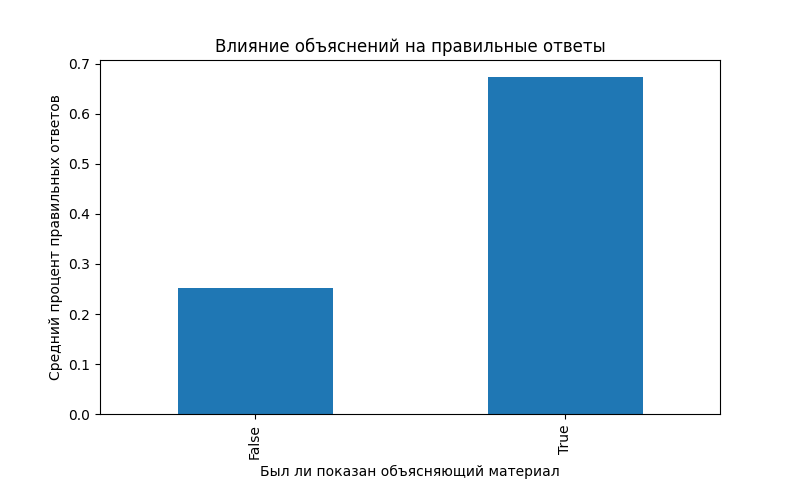
### Влияние объяснений на правильные ответы

Графие демонстрирует влияние наличия объяснений на процент правильных ответов студентов.

**Наблюдения:**
- Когда объяснения были предоставлены (значение `True` на графике), средний процент правильных ответов составляет около 70%.
- Когда объяснения отсутствовали (значение `False` на графике), средний процент правильных ответов значительно ниже и составляет около 30%.

**Интерпретация:**
- Наличие объясняющего материала существенно повышает вероятность того, что студент ответит правильно.
- Это может означать, что студенты лучше понимают материал и лучше справляются с вопросами, если они видят объяснение.

**Рекомендации:**
- Рассмотреть возможность включения объясняющих материалов ко всем вопросам, чтобы улучшить успеваемость.
- Провести дальнейший анализ, чтобы понять, в каких именно случаях объяснения особенно полезны (например, для вопросов определенной сложности или тематики).



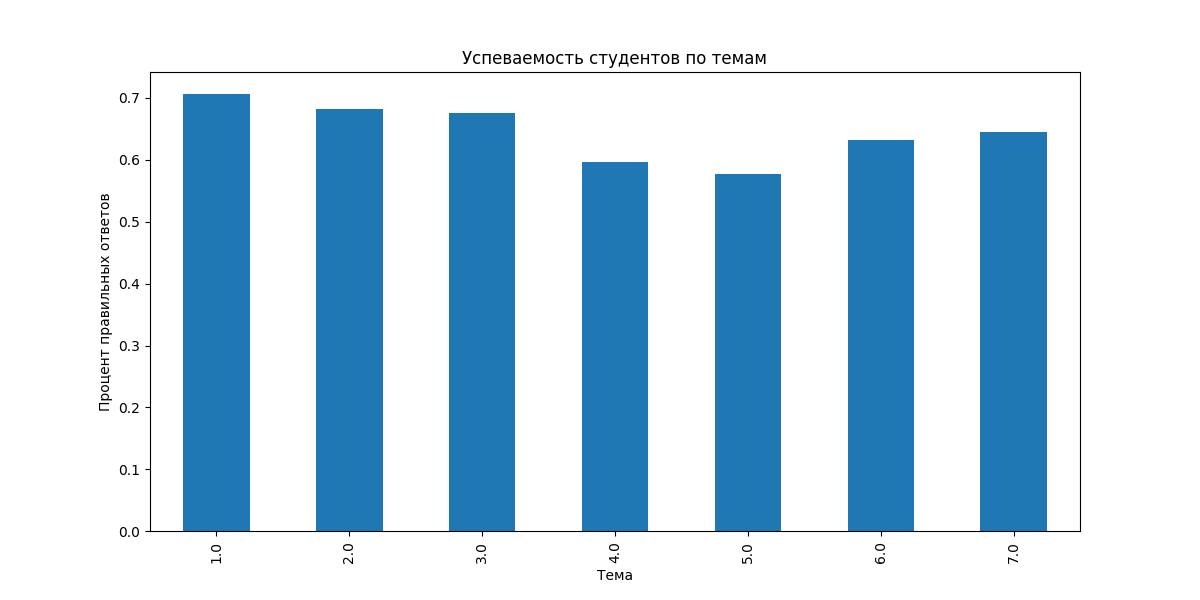
### Успеваемость студентов по темам

Графие демонстрирует успеваемость студентов в зависимости от тем, представленных в виде категорий от 1 до 7.

**Наблюдения:**
- Успеваемость студентов в разных темах варьируется в диапазоне от 60% до 70%.
- Темы 1 и 3 показывают наибольший процент правильных ответов (около 70%), что может говорить о том, что эти темы являются легче усваиваемыми для студентов или имеют более понятные объяснения.
- Темы 4 и 5 имеют более низкий процент правильных ответов, что может свидетельствовать о более сложном материале или необходимости в улучшении методики преподавания.

**Интерпретация:**
- Различия в успеваемости по темам могут быть связаны с разной сложностью содержания или различиями в качестве предоставляемых объяснений.
- Возможно, темы 4 и 5 требуют дополнительных объяснений или изменённого подхода к преподаванию.

**Рекомендации:**
- Провести более глубокий анализ, чтобы выяснить, какие конкретные аспекты тем 4 и 5 вызывают трудности у студентов.
- Рассмотреть возможность улучшения учебных материалов и добавления объясняющих лекций для этих тем.



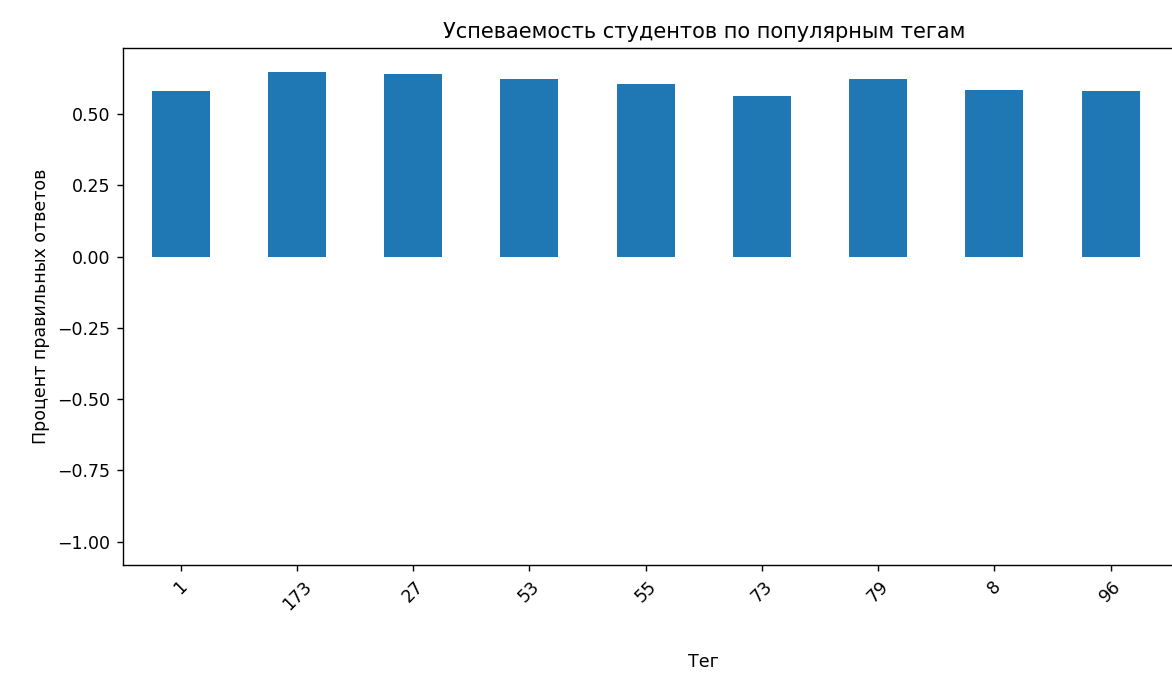
### Успеваемость студентов по популярным тегам

Графие демонстрирует процент правильных ответов студентов в зависимости от наиболее популярных тегов.

**Наблюдения:**
- Успеваемость студентов по популярным тегам колеблется в диапазоне от 50% до 55%.
- Теги 1, 173, и 27 показывают примерно одинаковую успеваемость, которая находится ближе к верхней границе этого диапазона.
- Все теги показывают относительно схожие результаты, без ярко выраженных лидеров или отстающих.

**Интерпретация:**
- Сравнительно равномерное распределение правильных ответов по тегам говорит о том, что сложность вопросов с различными тегами примерно одинакова.
- Не выделяются теги, которые были бы особенно сложными или простыми для студентов, что может свидетельствовать о хорошо сбалансированной сложности учебного материала.

**Рекомендации:**
- Провести дальнейший анализ, чтобы выявить потенциальные различия в успеваемости студентов в зависимости от различных комбинаций тегов, что может дать больше понимания о сложности определённых тем или концепций.
- Также можно исследовать связь между успеваемостью и другими признаками, такими как наличие объяснений или количество времени, потраченное на вопросы с этими тегами.

с этими тегами.



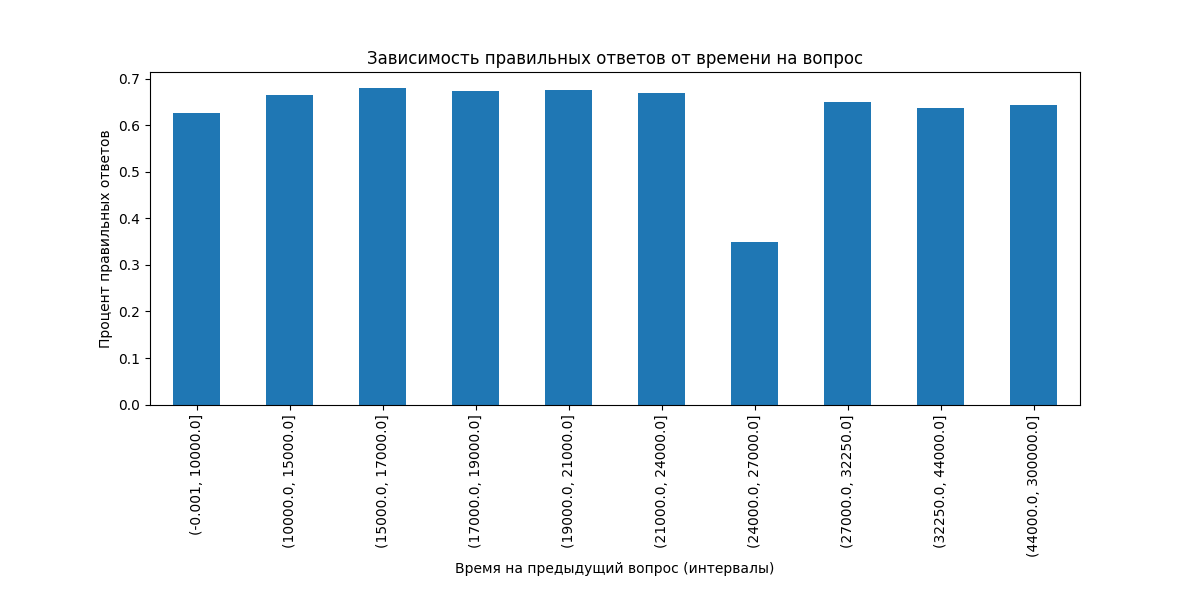
### Зависимость правильных ответов от времени на вопрос

Графие показывает процент правильных ответов студентов в зависимости от времени, затраченного на предыдущий вопрос, разбиенного на интервалы.

**Наблюдения:**
- Процент правильных ответов для большинства временных интервалов колеблется около 65-70%.
- Временные интервалы от 24 000 до 27 000 мс показывают значительное снижение процента правильных ответов, который падает ниже 50%.
- Большинство временных интервалов (кроме одного) показывают примерно равный уровень успешности, что говорит о том, что время, затраченное на вопрос, не всегда коррелирует с результатом.

**Интерпретация:**
- Падение успешности в интервале 24 000-27 000 мс может указывать на то, что слишком долгое размышление над вопросом приводит к снижению концентрации и, соответственно, вероятности правильного ответа.
- Высокий процент правильных ответов в остальных временных интервалах указывает на то, что умеренное время на ответ связано с более уверенными и точными решениями.

**Рекомендации:**
- Проанализировать содержание вопросов, на которые затрачено больше 24 000 мс, чтобы определить, являются ли они слишком сложными или требуют слишком много времени.
- Рассмотреть возможность добавления стратегий обучения, которые помогут студентам эффективно управлять временем, чтобы не тратить слишком много времени на отдельные вопросы.



### Финальный анализ данных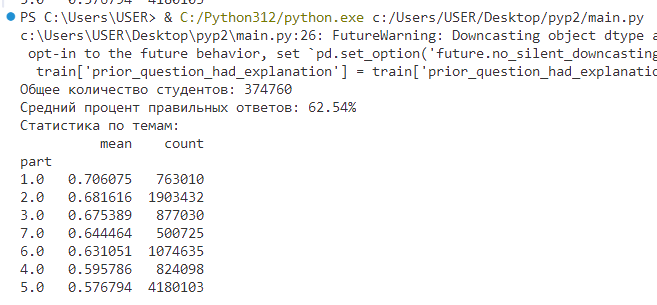

В данном разделе представлен анализ общего количества студентов, среднего процента правильных ответов и статистики по темам.

#### Общее количество студентов
- **Общее количество студентов**: 374 760

**Интерпретация**:
- Данное количество студентов предоставляет хорошую выборку для анализа успеваемости по различным темам и факторам. Размер выборки позволяет уверенно оценивать статистику и находить закономерности.

#### Средний процент правильных ответов
- **Средний процент правильных ответов**: 62.54%

**Интерпретация**:
- Средний процент правильных ответов составляет примерно 62.54%. Это говорит о том, что, в среднем, более половины студентов успешно справляются с вопросами, однако есть значительные возможности для улучшения. 

**Рекомендации**:
- Провести более глубокий анализ для выявления причин, которые могут снижать успеваемость (например, сложные темы, отсутствие объяснений).
- Рассмотреть возможность внедрения дополнительных обучающих материалов или пересмотра вопросов, которые вызывают трудности.

#### Статистика по темам
Статистика по темам показывает средний процент правильных ответов и количество вопросов по каждой из представленных тем.

| Тема (part) | Средний процент правильных ответов | Количество вопросов |
|-------------|-----------------------------------|---------------------|
| 1.0         | 70.61%                            | 763 010             |
| 2.0         | 68.16%                            | 1 903 432           |
| 3.0         | 67.54%                            | 877 030             |
| 7.0         | 64.45%                            | 500 725             |
| 6.0         | 63.11%                            | 1 074 635           |
| 4.0         | 59.58%                            | 824 098             |
| 5.0         | 57.68%                            | 4 180 103           |

**Наблюдения**:
- Темы 1, 2 и 3 демонстрируют наибольший процент правильных ответов, с максимальным значением у темы 1 (70.61%).
- Темы 4 и 5 имеют наименьший процент правильных ответов, с минимальным значением у темы 5 (57.68%). Это может свидетельствовать о повышенной сложности вопросов или недостаточной подготовленности студентов по этим темам.

**Интерпретация**:
- Темы 1, 2 и 3 могут быть либо лучше объяснены, либо имеют более легкие вопросы. 
- Темы 4 и 5 требуют дополнительного внимания, так как они имеют наименьшую успеваемость.

**Рекомендации**:
- Рассмотреть возможность улучшения учебных материалов для тем 4 и 5, возможно, добавив больше объясняющих лекций или примеров.
- Проанализировать вопросы из тем 4 и 5, чтобы понять, какие конкретные аспекты вызывают трудности у студентов.
- Поддерживать высокий уровень объяснений и преподавания по темам 1, 2 и 3, чтобы сохранить высокую успеваемость.

